
Conteo de Imágenes por Categoría:
               Categoría  Cantidad de Imágenes
0             Sentadilla                   938
1  elevaciones laterales                   843
2         Press de banca                   780
3            Peso Muerto                   728
4         curl de biceps                   705
5        press de hombro                   512

Resolución Media por Categoría:
               Categoría  Ancho Medio (pixels)  Alto Medio (pixels)
0            Peso Muerto            594.750000           474.259615
1         Press de banca            573.096154           421.794872
2             Sentadilla            559.420043           429.039446
3         curl de biceps            489.917730           370.734752
4  elevaciones laterales            504.256228           374.549229
5        press de hombro            500.990234           381.582031

Tamaño de Archivo Medio por Categoría (en MB):
               Categoría  Tamaño Medio (MB)
0            Peso Muerto           

C:\Users\Diego Castillo\AppData\Local\Temp\ipykernel_18648\1286052354.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resolution_mean, x='Categoría', y='Ancho Medio (pixels)', palette="Blues_d")


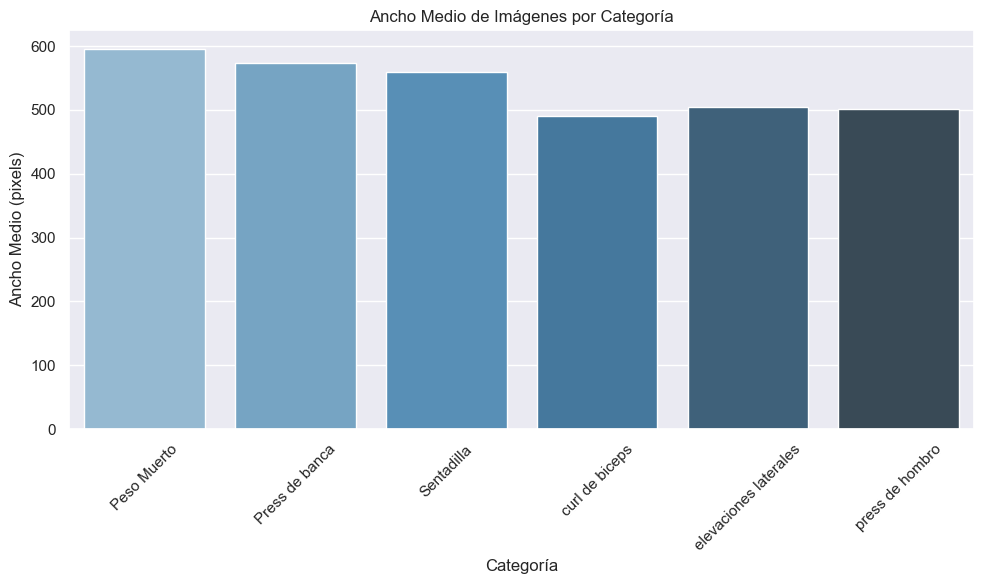

C:\Users\Diego Castillo\AppData\Local\Temp\ipykernel_18648\1286052354.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resolution_mean, x='Categoría', y='Alto Medio (pixels)', palette="Blues_d")


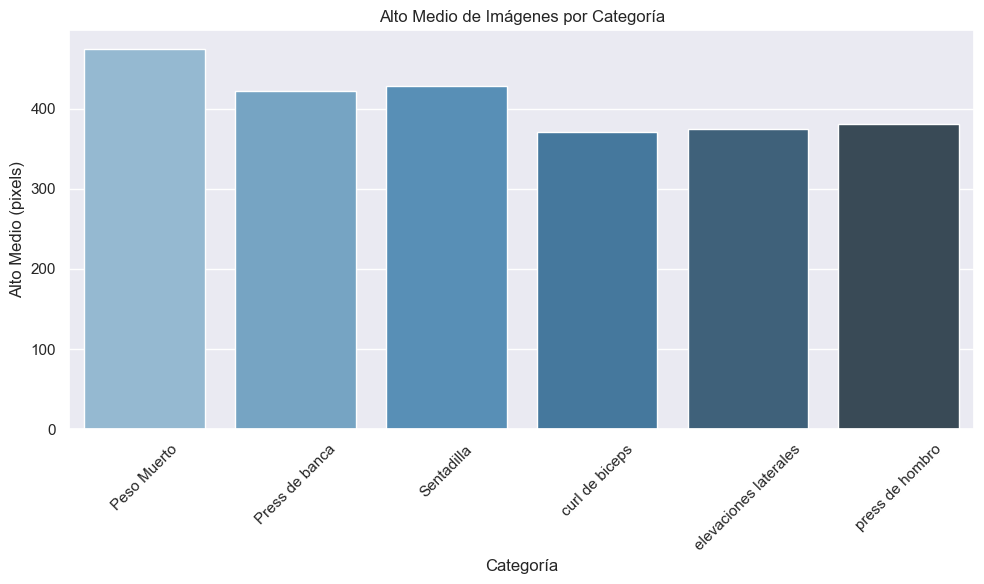

C:\Users\Diego Castillo\AppData\Local\Temp\ipykernel_18648\1286052354.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_mean, x='Categoría', y='Tamaño Medio (MB)', palette="Blues_d")


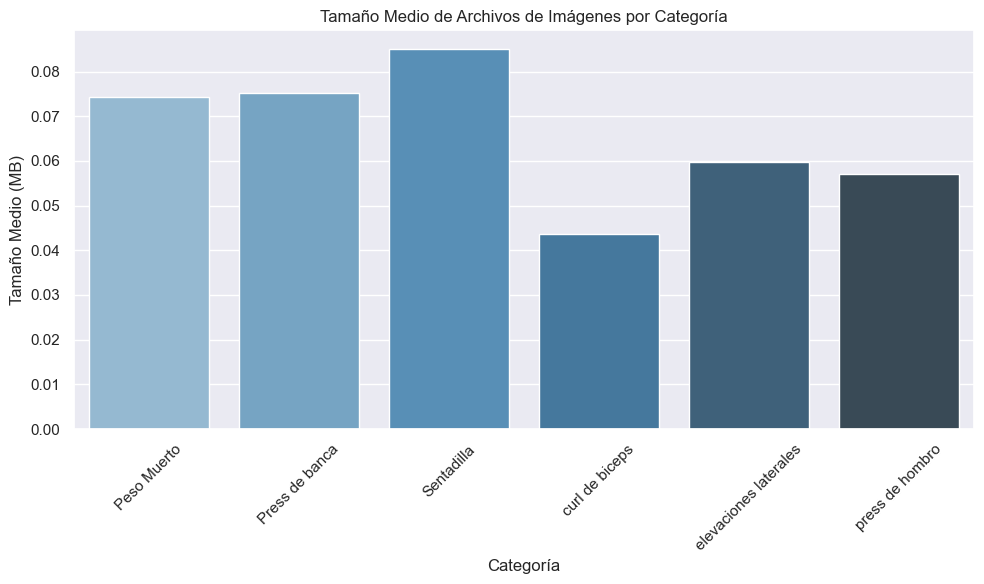

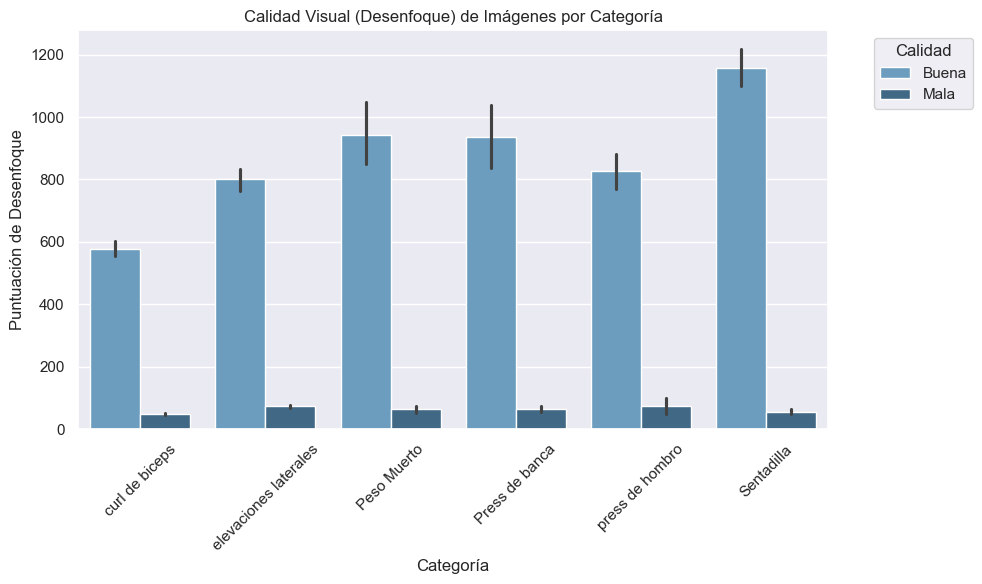

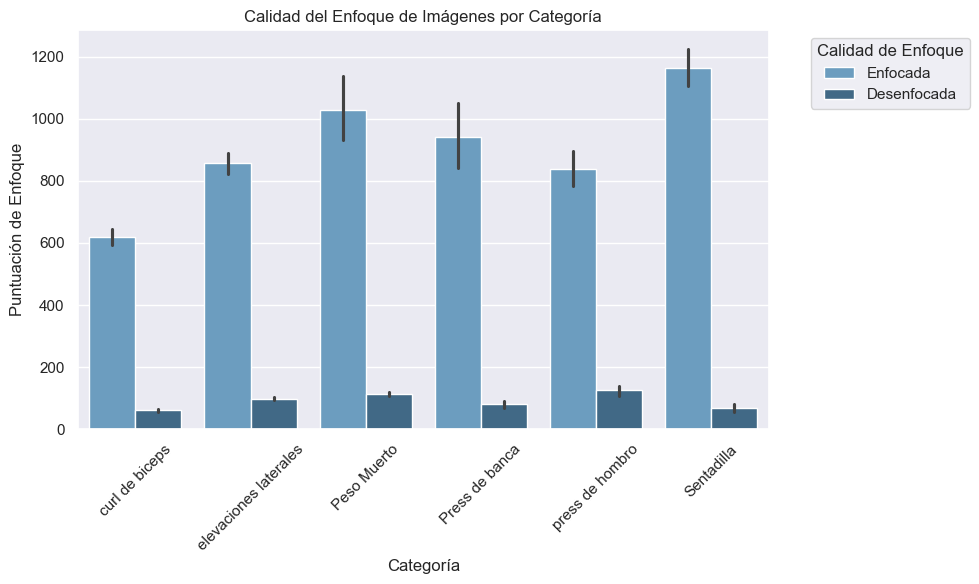

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración para gráficos
sns.set(style="darkgrid", palette="Blues")

# Definir rutas
ruta_actual = os.getcwd()
ruta_raiz = os.path.dirname(ruta_actual)
data_dir = os.path.join(ruta_raiz, 'Data Set', 'images')
categories = os.listdir(data_dir)

# Contenedores para resultados
image_info = []

# Función para procesar una imagen y extraer metadata
def analyze_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Obtener metadata
    height, width, channels = img.shape
    size = os.path.getsize(image_path)
    
    return {
        'width': width,
        'height': height,
        'channels': channels,
        'size': size
    }

# Función para evaluar la calidad visual de la imagen
def evaluate_visual_quality(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_score = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    
    return blur_score

# Función para evaluar la calidad del enfoque
def evaluate_focus_quality(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    focus_score = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    
    return focus_score

# Recorre las categorías y procesa las imágenes
for category in categories:
    category_path = os.path.join(data_dir, category)
    if not os.path.isdir(category_path):
        continue
    
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        metadata = analyze_image(image_path)
        if metadata:
            metadata.update({'category': category, 'image': image})
            blur_score = evaluate_visual_quality(image_path)
            focus_score = evaluate_focus_quality(image_path)
            metadata['blur_score'] = blur_score
            metadata['focus_score'] = focus_score
            image_info.append(metadata)

# Convertir a DataFrame
image_info_df = pd.DataFrame(image_info)

# Definir umbral para mala calidad
umbral_mala_calidad = 100  # Ajusta según necesidad
umbral_buen_enfoque = 150  # Ajusta según necesidad
image_info_df['Calidad'] = image_info_df['blur_score'].apply(lambda x: 'Mala' if x < umbral_mala_calidad else 'Buena')
image_info_df['Calidad_Enfoque'] = image_info_df['focus_score'].apply(lambda x: 'Desenfocada' if x < umbral_buen_enfoque else 'Enfocada')

# Guardar la información de imágenes en Excel
excel_file = 'image_analysis.xlsx'
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    image_info_df.to_excel(writer, sheet_name='Image_Info', index=False)

    # Tablas de análisis
    image_count = image_info_df['category'].value_counts().reset_index()
    image_count.columns = ['Categoría', 'Cantidad de Imágenes']
    image_count.to_excel(writer, sheet_name='Conteo_Imagenes', index=False)

    resolution_mean = image_info_df.groupby('category')[['width', 'height']].mean().reset_index()
    resolution_mean.columns = ['Categoría', 'Ancho Medio (pixels)', 'Alto Medio (pixels)']
    resolution_mean.to_excel(writer, sheet_name='Resolución_Media', index=False)

    image_info_df['size_MB'] = image_info_df['size'] / (1024 * 1024)
    size_mean = image_info_df.groupby('category')['size_MB'].mean().reset_index()
    size_mean.columns = ['Categoría', 'Tamaño Medio (MB)']
    size_mean.to_excel(writer, sheet_name='Tamaño_Medio', index=False)

    # Nuevo análisis: Promedio de la puntuación de desenfoque por categoría
    blur_score_mean = image_info_df.groupby('category')['blur_score'].mean().reset_index()
    blur_score_mean.columns = ['Categoría', 'Puntuación de Desenfoque Media']
    blur_score_mean.to_excel(writer, sheet_name='Blur_Score_Medio', index=False)

    visual_quality = image_info_df[['category', 'image', 'blur_score', 'focus_score', 'Calidad', 'Calidad_Enfoque']]
    visual_quality.columns = ['Categoría', 'Imagen', 'Puntuación de Desenfoque', 'Puntuación de Enfoque', 'Calidad', 'Calidad de Enfoque']
    visual_quality.to_excel(writer, sheet_name='Calidad_Visual', index=False)

# Mostrar tablas
print("\nConteo de Imágenes por Categoría:")
print(image_count)

print("\nResolución Media por Categoría:")
print(resolution_mean)

print("\nTamaño de Archivo Medio por Categoría (en MB):")
print(size_mean)

print("\nPuntuación Media de Desenfoque por Categoría:")
print(blur_score_mean)

print("\nCalidad Visual (Desenfoque) para Todas las Imágenes:")
print(visual_quality[['Categoría', 'Imagen', 'Puntuación de Desenfoque', 'Calidad']])

print("\nCalidad del Enfoque para Todas las Imágenes:")
print(visual_quality[['Categoría', 'Imagen', 'Puntuación de Enfoque', 'Calidad de Enfoque']])

# Visualización de Resultados

# Gráfico: Resolución Media de Imágenes por Categoría
plt.figure(figsize=(10, 6))
sns.barplot(data=resolution_mean, x='Categoría', y='Ancho Medio (pixels)', palette="Blues_d")
plt.title('Ancho Medio de Imágenes por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Ancho Medio (pixels)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Ancho_Medio_por_Categoria.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=resolution_mean, x='Categoría', y='Alto Medio (pixels)', palette="Blues_d")
plt.title('Alto Medio de Imágenes por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Alto Medio (pixels)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Alto_Medio_por_Categoria.png')
plt.show()

# Gráfico: Tamaño de Archivos por Categoría
plt.figure(figsize=(10, 6))
sns.barplot(data=size_mean, x='Categoría', y='Tamaño Medio (MB)', palette="Blues_d")
plt.title('Tamaño Medio de Archivos de Imágenes por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Tamaño Medio (MB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Tamano_Medio_por_Categoria.png')
plt.show()

# Gráfico: Calidad Visual (Desenfoque) de Todas las Imágenes
plt.figure(figsize=(10, 6))
sns.barplot(data=image_info_df, x='category', y='blur_score', hue='Calidad', palette="Blues_d")
plt.title('Calidad Visual (Desenfoque) de Imágenes por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Puntuación de Desenfoque')
plt.xticks(rotation=45)
plt.legend(title='Calidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Calidad_Visual_Imagenes.png')
plt.show()

# Gráfico: Calidad del Enfoque de Todas las Imágenes
plt.figure(figsize=(10, 6))
sns.barplot(data=image_info_df, x='category', y='focus_score', hue='Calidad_Enfoque', palette="Blues_d")
plt.title('Calidad del Enfoque de Imágenes por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Puntuación de Enfoque')
plt.xticks(rotation=45)
plt.legend(title='Calidad de Enfoque', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Calidad_Enfoque_Imagenes.png')
plt.show()
